In [1]:
!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2022-02-17 11:41:45 +01:00)


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

time: 16 ms (started: 2022-02-17 11:41:52 +01:00)


In [3]:
import os
import pandas as pd
import numpy as np
import time
import datetime
import itertools
import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('fivethirtyeight')

from skimage import io

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense,Activation,Input,Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D

time: 7.66 s (started: 2022-02-17 11:42:02 +01:00)


In [7]:
#define directory path => adapted to my laptop
root_dir ='C:/Users/ANTOINE/Project_Mushroom/' 
raw_data_dir = root_dir + 'raw_data/' #raw images folder
DL_dir = root_dir + 'deep_learning/' #Deep Learning folder

csv_file_paths = 'image_and_json_data.csv'



time: 0 ns (started: 2022-02-17 11:43:06 +01:00)


In [8]:
csv_file_paths = 'image_and_json_data.csv'
df_paths = pd.read_csv(root_dir + csv_file_paths)
print('{} rows in the file'.format(len(df_paths)))
df_paths .head()

208774 rows in the file


,file_name,file_path,resolution,file_year,image_id,format,observation,label,image_url,user,...,gbif_info.canonicalName,gbif_info.phylumKey,gbif_info.class,gbif_info.synonym,gbif_info.scientificName,gbif_info.genus,gbif_info.order,gbif_info.note,gbif_info,json_file
0,1208.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(243, 320)",ages,1208,jpg,1007,Agaricales,http://mushroomobserver.org/images/320/1208,25,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
1,1604.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(320, 164)",ages,1604,jpg,1535,Agaricales,http://mushroomobserver.org/images/320/1604,43,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
2,1608.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(320, 286)",ages,1608,jpg,1537,Agaricales,http://mushroomobserver.org/images/320/1608,43,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
3,29.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(240, 320)",ages,29,jpg,23,Agaricales,http://mushroomobserver.org/images/320/29,1,...,Agaricales,34.0,Agaricomycetes,False,Agaricales,NaN,Agaricales,NaN,NaN,row_data\json\observations_0.json
4,680.jpg,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,"(240, 320)",ages,680,jpg,536,Agaricus,http://mushroomobserver.org/images/320/680,1,...,Agaricus,34.0,Agaricomycetes,False,Agaricus,Agaricus,Agaricales,NaN,NaN,row_data\json\observations_0.json


time: 1.28 s (started: 2022-02-17 11:43:10 +01:00)


In [9]:
#select only 320,240 images with family info
df_paths = df_paths[df_paths['resolution']=='(320, 240)']

# drop na 
df_paths = df_paths[df_paths['gbif_info.family'].notna()]

# keep conf level over 90 
df_paths = df_paths.loc[df_paths['gbif_info.confidence']>90]

# keep only most common class
top_class = df_paths['gbif_info.class'].value_counts().index[0]
df_paths = df_paths[df_paths['gbif_info.class'] == top_class]
print(df_paths['gbif_info.class'].value_counts())

# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

Agaricomycetes    72246
Name: gbif_info.class, dtype: int64


,gbif_info.family,size
0,Agaricaceae,5090
1,Albatrellaceae,200
2,Amanitaceae,4679
3,Amylocorticiaceae,16
4,Amylostereaceae,6
...,...,...
99,Tubariaceae,212
100,Tulasnellaceae,37
101,Tulostomataceae,2
102,Typhulaceae,39


time: 172 ms (started: 2022-02-17 11:43:25 +01:00)


In [10]:
# keep only top 7 families 
top_fam = df_paths['gbif_info.family'].value_counts().index[:7].values
df_paths = df_paths[df_paths['gbif_info.family'].isin(top_fam)]

# Check number of classes 
pd.DataFrame(df_paths.groupby(['gbif_info.family'], as_index=False).size())

,gbif_info.family,size
0,Agaricaceae,5090
1,Amanitaceae,4679
2,Boletaceae,5977
3,Cortinariaceae,3931
4,Russulaceae,5911
5,Strophariaceae,4369
6,Tricholomataceae,4601


time: 31 ms (started: 2022-02-17 11:43:34 +01:00)


In [11]:
# subset col of interest + label encoding
df = df_paths[['file_path','gbif_info.family']].copy()
df['label'] = df['gbif_info.family'].replace(df['gbif_info.family'].unique(), [*range(len(df['gbif_info.family'].unique()))]).astype(str) # label encoding 

df.head()

,file_path,gbif_info.family,label
5,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
6,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
7,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
8,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0
9,C:/Users/ANTOINE/Project_Mushroom/row_data\ima...,Agaricaceae,0


time: 63 ms (started: 2022-02-17 11:43:42 +01:00)


In [12]:
# compute number of classes
print('number of rows = {}'.format(len(df['label'])))
dict_label_df = pd.DataFrame(df.groupby(['label','gbif_info.family'], as_index=False).size())
classes_count = len(dict_label_df)
dict_label_df

number of rows = 34558


,label,gbif_info.family,size
0,0,Agaricaceae,5090
1,1,Strophariaceae,4369
2,2,Amanitaceae,4679
3,3,Boletaceae,5977
4,4,Tricholomataceae,4601
5,5,Cortinariaceae,3931
6,6,Russulaceae,5911


time: 16 ms (started: 2022-02-17 11:43:50 +01:00)


In [13]:
# CREATE DICT LABELS 
dict_label = dict(dict_label_df[['label','gbif_info.family']].values)
dict_label

{'0': 'Agaricaceae',
 '1': 'Strophariaceae',
 '2': 'Amanitaceae',
 '3': 'Boletaceae',
 '4': 'Tricholomataceae',
 '5': 'Cortinariaceae',
 '6': 'Russulaceae'}

time: 0 ns (started: 2022-02-17 11:43:59 +01:00)


In [14]:
# Train/test
df_train,df_test=train_test_split(df, train_size=0.8, stratify =df['label'], random_state=42)
# train / val 
df_train_,df_val_=train_test_split(df_train, train_size=0.8,stratify =df_train['label'],random_state=42)
print(df_train_.shape,df_val_.shape,df_test.shape)

(22116, 3) (5530, 3) (6912, 3)
time: 62 ms (started: 2022-02-17 11:44:06 +01:00)


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_data = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                     x_col = "file_path",y_col="label", 
                                                     shuffle = False, # to match df_test order 
                                                     target_size=(240,320),
                                                     batch_size=16,
                                                     class_mode='sparse')

Found 6912 validated image filenames belonging to 7 classes.
time: 1.83 s (started: 2022-02-17 11:44:19 +01:00)


In [16]:
efficientnet_final = tf.keras.models.load_model(root_dir + 'EFB1_final_model')

time: 17.2 s (started: 2022-02-17 11:44:50 +01:00)


In [18]:
#assess performances 
start=time.time()
test_pred_class=[]
for i in range(430):
    test_pred_class_temp = efficientnet_final.predict(test_data[i][0]).argmax(axis = 1) # predictions test
    test_pred_class=np.concatenate([test_pred_class,test_pred_class_temp])
total_time=time.time()
print('durée totale calcul :',total_time)

durée totale calcul : 1645095877.432815
time: 8min 53s (started: 2022-02-17 11:55:43 +01:00)


In [24]:
print(test_data)

time: 0 ns (started: 2022-02-17 12:08:08 +01:00)


In [20]:
#confusion matrix
y_test_class=[]
for i in range(430):
    y_test_class=np.concatenate([y_test_class,test_data[i][1]])
print(metrics.classification_report(y_test_class, test_pred_class))

              precision    recall  f1-score   support

         0.0       0.87      0.77      0.82      1013
         1.0       0.82      0.82      0.82       870
         2.0       0.91      0.89      0.90       931
         3.0       0.91      0.92      0.91      1189
         4.0       0.82      0.80      0.81       914
         5.0       0.78      0.90      0.84       783
         6.0       0.90      0.92      0.91      1180

    accuracy                           0.86      6880
   macro avg       0.86      0.86      0.86      6880
weighted avg       0.86      0.86      0.86      6880

time: 9.83 s (started: 2022-02-17 12:05:03 +01:00)


# post pred

In [25]:
y_test_class_df=pd.DataFrame(y_test_class)
y_test_count=pd.DataFrame(y_test_class_df.value_counts(),columns=['y_test_count'])
y_test_count=y_test_count.sort_index()
test_dict_label=pd.DataFrame(dict_label,index=['family']).transpose()
test_dict_label['y_test_count']=y_test_count['y_test_count'].values
test_dict_label=test_dict_label.reset_index()
test_dict_label=test_dict_label.rename({'index':'label'},axis=1)
test_dict_label

,label,family,y_test_count
0,0,Agaricaceae,1013
1,1,Strophariaceae,870
2,2,Amanitaceae,931
3,3,Boletaceae,1189
4,4,Tricholomataceae,914
5,5,Cortinariaceae,783
6,6,Russulaceae,1180


time: 32 ms (started: 2022-02-17 12:08:54 +01:00)


In [26]:
test_pred_class=pd.DataFrame(test_pred_class)
test_pred_class=test_pred_class.rename({0:'pred_class'},axis=1)
test_pred_class

,pred_class
0,5.0
1,3.0
2,6.0
3,5.0
4,6.0
...,...
6875,3.0
6876,5.0
6877,4.0
6878,0.0


time: 0 ns (started: 2022-02-17 12:09:02 +01:00)


In [27]:
y_test_class_df=y_test_class_df.rename({0:'real_class'},axis=1)
y_test_class_df

,real_class
0,5.0
1,3.0
2,6.0
3,5.0
4,6.0
...,...
6875,3.0
6876,5.0
6877,4.0
6878,0.0


time: 0 ns (started: 2022-02-17 12:09:11 +01:00)


In [28]:
#sélection des indices par class parmi les 7158 images de Test
good_pred_indexes=[]
good_pred_indexes_class0=[]
good_pred_indexes_class1=[]
good_pred_indexes_class2=[]
good_pred_indexes_class3=[]
good_pred_indexes_class4=[]
good_pred_indexes_class5=[]
good_pred_indexes_class6=[]
for i in range(len(test_pred_class['pred_class'])):
    if (test_pred_class['pred_class'].iloc[i]==y_test_class_df['real_class'].iloc[i]):
        good_pred_indexes+=[i]
        if y_test_class_df['real_class'].iloc[i]==0:
            good_pred_indexes_class0+=[i]
        elif y_test_class_df['real_class'].iloc[i]==1:
            good_pred_indexes_class1+=[i]
        elif y_test_class_df['real_class'].iloc[i]==2:
            good_pred_indexes_class2+=[i]
        elif y_test_class_df['real_class'].iloc[i]==3:
            good_pred_indexes_class3+=[i]
        elif y_test_class_df['real_class'].iloc[i]==4:
            good_pred_indexes_class4+=[i]
        elif y_test_class_df['real_class'].iloc[i]==5:
            good_pred_indexes_class5+=[i]
        elif y_test_class_df['real_class'].iloc[i]==6:
            good_pred_indexes_class6+=[i]

time: 235 ms (started: 2022-02-17 12:09:20 +01:00)


In [29]:
print(np.array(good_pred_indexes_class0).size)
print(np.array(good_pred_indexes_class1).size)
print(np.array(good_pred_indexes_class2).size)
print(np.array(good_pred_indexes_class3).size)
print(np.array(good_pred_indexes_class4).size)
print(np.array(good_pred_indexes_class5).size)
print(np.array(good_pred_indexes_class6).size)
print(np.array(good_pred_indexes).size)

783
711
830
1096
733
704
1081
5938
time: 0 ns (started: 2022-02-17 12:09:27 +01:00)


In [30]:
family_names=test_dict_label['family']
family_names

0         Agaricaceae
1      Strophariaceae
2         Amanitaceae
3          Boletaceae
4    Tricholomataceae
5      Cortinariaceae
6         Russulaceae
Name: family, dtype: object

time: 0 ns (started: 2022-02-17 12:09:37 +01:00)


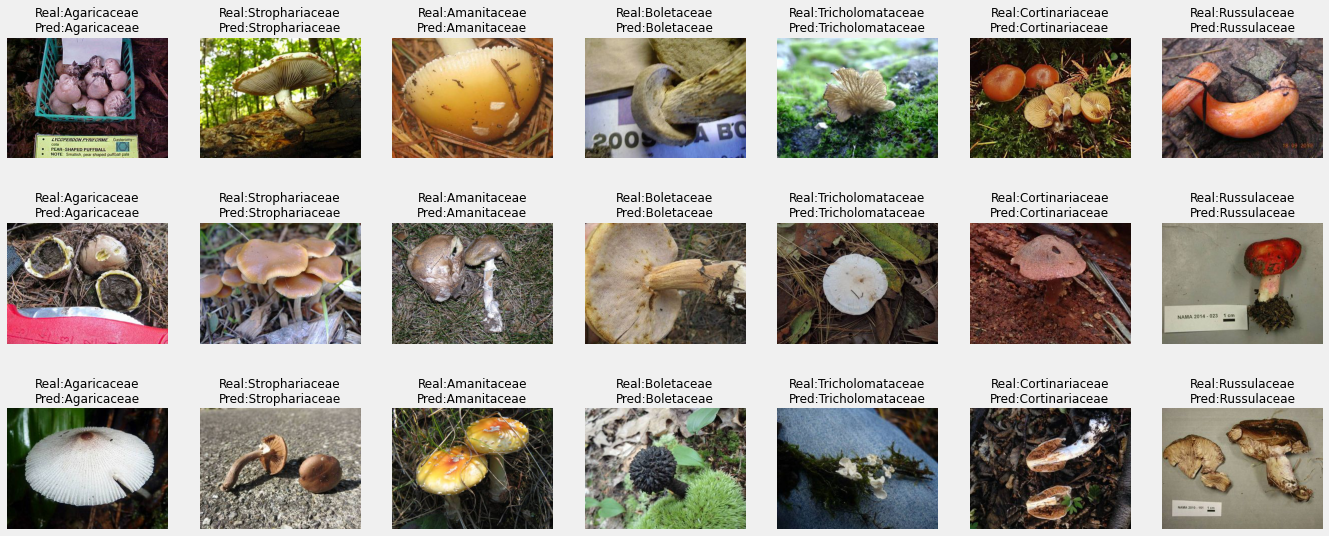

time: 1.2 s (started: 2022-02-17 12:10:23 +01:00)


In [32]:
fig,axs=plt.subplots(3,7,figsize=(21,9))
for col in range(7):
    if col==0:
        row=0
        for i in np.random.choice(good_pred_indexes_class0,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==1:
        row=0
        for i in np.random.choice(good_pred_indexes_class1,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==2:
        row=0
        for i in np.random.choice(good_pred_indexes_class2,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==3:
        row=0
        for i in np.random.choice(good_pred_indexes_class3,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==4:
        row=0
        for i in np.random.choice(good_pred_indexes_class4,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==5:
        row=0
        for i in np.random.choice(good_pred_indexes_class5,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
    elif col==6:
        row=0
        for i in np.random.choice(good_pred_indexes_class6,size=3):
            batch=i//16
            indice=i%16
            im=np.array(test_data[batch][0][indice],dtype=np.uint8)
            axs[row,col].imshow(im)
            axs[row,col].set_title('Real:'+family_names[col]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[i]],fontsize=12)
            axs[row,col].axis('off')
            row+=1
#fig.savefig(root_dir +'Deep_learning/220215_02H39/EfficientNetB1_(240, 320)_7families_all_images_good_pred_examples.jpeg' );

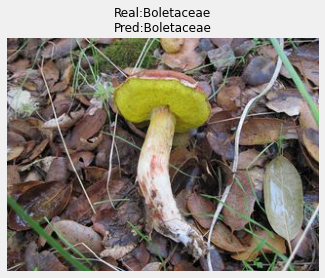

time: 94 ms (started: 2022-02-17 12:10:52 +01:00)


In [33]:
# choix manuel indice class3 (car meilleur f1-score pour la class2)
indice=good_pred_indexes_class3[6]
batch=indice//16
i=indice%16

#affichage de l'image choisie
fig=plt.figure()
im=np.array(test_data[batch][0][i],dtype=np.uint8) #[batch][0][indice]
plt.imshow(im)
plt.title('Real:'+family_names[3]+'\n'+'Pred:'+family_names[test_pred_class['pred_class'].iloc[indice]],fontsize=12)
plt.axis('off');

In [34]:
input_tensor = tf.keras.Input(shape=(240,320,3)) #input with the shape of the images to be processed

#base_model = EfficientNetB1 without top layers of classification
#with weights from efficientnet_final => not possible
from tensorflow.keras.applications import EfficientNetB1
#weights_base=efficientnet_final.layers[0].weights
base_model=EfficientNetB1(weights='imagenet',include_top=False,
                          input_tensor = input_tensor)

#identify the last convolution layer
last_conv = base_model.get_layer('top_conv')

#define the model from the last_conv layer
#all the layers are the same as the customised efficientnet classification top layers
#with weights from efficientnet_final
x = GlobalAveragePooling2D()(last_conv.output)
x= Dense(1024, activation='relu',weights=efficientnet_final.layers[2].weights)(x)
x= Dropout(0.3)(x)
x= Dense(512, activation='relu',weights=efficientnet_final.layers[4].weights)(x)
x = Dropout(0.2)(x)
x = Dense(7, activation='softmax')(x)
new_model = tf.keras.models.Model(inputs=input_tensor, outputs=x)

27033600/27018416 [==============================] - 1s 0us/step
time: 2.27 s (started: 2022-02-17 12:11:31 +01:00)


# Shap

In [42]:
efficientnet_final.summary()

Model: "EFB1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 10, 1280)      6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                              

In [110]:
import shap
test_generator = ImageDataGenerator().flow_from_dataframe(dataframe = df_test,
                                                        x_col = "file_path",y_col="label", 
                                                          shuffle = False,
                                                          target_size=(240, 320),batch_size=16,class_mode='sparse')


batch = next(iter(test_generator))
images, _ = batch
print(images.shape)
background = images[:10]
test_images= images[10:16]
explainer = shap.DeepExplainer(new_model, images)


Found 6912 validated image filenames belonging to 7 classes.
(16, 240, 320, 3)
time: 2.84 s (started: 2022-02-17 12:43:58 +01:00)


In [68]:
def get_img_array(img):
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# Prepare image
img_array = get_img_array(img=im)
img_array.shape

(1, 240, 320, 3)

time: 0 ns (started: 2022-02-17 12:30:02 +01:00)


In [93]:
test_images

[array([[[[ 32.,  27.,  23.],
          [ 32.,  27.,  23.],
          [ 32.,  27.,  23.],
          ...,
          [ 44.,  40.,  54.],
          [ 29.,  26.,  43.],
          [ 12.,   9.,  28.]],
 
         [[ 30.,  22.,  20.],
          [ 30.,  22.,  20.],
          [ 30.,  22.,  20.],
          ...,
          [ 35.,  33.,  46.],
          [ 28.,  25.,  42.],
          [ 22.,  19.,  38.]],
 
         [[ 31.,  19.,  21.],
          [ 31.,  19.,  21.],
          [ 31.,  19.,  21.],
          ...,
          [ 47.,  45.,  59.],
          [ 34.,  31.,  50.],
          [ 21.,  18.,  39.]],
 
         ...,
 
         [[152., 133., 139.],
          [107.,  92.,  87.],
          [ 74.,  61.,  52.],
          ...,
          [106., 112., 126.],
          [110., 116., 130.],
          [110., 116., 130.]],
 
         [[114.,  98.,  99.],
          [ 81.,  71.,  62.],
          [ 63.,  56.,  46.],
          ...,
          [116., 118., 130.],
          [113., 115., 127.],
          [106., 106., 118.

time: 0 ns (started: 2022-02-17 12:36:09 +01:00)


In [94]:
test_images.shape

AttributeError: 'list' object has no attribute 'shape'

time: 16 ms (started: 2022-02-17 12:36:43 +01:00)


In [106]:
image2 = images.reshape(16,3,320,240)

time: 0 ns (started: 2022-02-17 12:43:05 +01:00)


In [69]:
background = new_images[:10]
test_images= new_images[10:16]
explainer = shap.DeepExplainer(new_model, img_array)

time: 188 ms (started: 2022-02-17 12:30:15 +01:00)


In [109]:
shap_values = explainer.shap_values(images)

AttributeError: in user code:

    File "C:\Users\ANTOINE\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 243, in grad_graph  *
        out = self.model(shap_rAnD)
    File "C:\Users\ANTOINE\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\ANTOINE\anaconda3\lib\site-packages\shap\explainers\_deep\deep_tf.py", line 26, in custom_record_gradient
        out = tf_backprop._record_gradient("shap_"+op_name, inputs, attrs, results)

    AttributeError: Exception encountered when calling layer "rescaling" (type Rescaling).
    
    module 'tensorflow.python.eager.backprop' has no attribute '_record_gradient'
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(2, 240, 320, 3), dtype=float32)


time: 32 ms (started: 2022-02-17 12:43:34 +01:00)
